In [3]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet
import numpy as np

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [66]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, save_dir_, pre_model_save_path_, device):
        self.pre_model_save_path = pre_model_save_path_
        self.save_dir = save_dir_

        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        #parameters
        self.E = 210
        self.nu = 0.3
        self.G = self.E / (2 * (1 + self.nu))
        self.g = 0.0027
        self.l = 0.01

        #self.U_0 = 0
        self.device = device
        # Extrema of the solution domain (t,x,y) in [0,1]x[0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1],  # x dimension
                                            [0, 1]])  # y dimension
        # Number of space dimensions
        self.space_dimensions = 2

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=3,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''
        if pre_model_save_path_:
            self.load_checkpoint()

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition
    #def initial_condition(self, x):
        #return torch.full([len(x), 3], self.U_0)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_initial_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        y0 = self.domain_extrema[2, 0]
        yL = self.domain_extrema[2, 1]

        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
    
        input_tb_0 = torch.clone(input_tb)
        mask_0 = ((input_tb_0[:, 1] >= x0) & (input_tb_0[:, 1] <= xL) & ((input_tb_0[:, 2] >= y0) & (input_tb_0[:, 2] <= 0.49)) |
            ((input_tb_0[:, 1] >= x0) & (input_tb_0[:, 1] <= xL) & (input_tb_0[:, 2] >= 0.51) & (input_tb_0[:, 2] <= yL)))
        input_tb_0 = input_tb_0[mask_0]
        output_tb_0 = torch.zeros((input_tb.shape[0], 1))

        input_tb_1 = torch.clone(input_tb)
        mask_1 = ((input_tb_1[:, 1] >= x0) & (input_tb_1[:, 1] <= 0.5) & ((input_tb_1[:, 2] > 0.49) & (input_tb_1[:, 2] < 0.51)))
        input_tb_1 = input_tb_1[mask_1]

        output_tb_1 = torch.zeros((input_tb.shape[0], 1))
        #output_tb_1[:, 2] = torch.full(output_tb_1[:, 2].shape, 1)
    
        print("input_tb_1:", input_tb_1)
        print("mask_1:", mask_1)

        return torch.cat([input_tb_0, input_tb_1], 0), torch.cat([output_tb_0, output_tb_1], 0)
        

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        y0 = self.domain_extrema[2, 0]
        yL = self.domain_extrema[2, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, x0)
        input_sb_D = torch.clone(input_sb)
        input_sb_D[:, 2] = torch.full(input_sb_D[:, 2].shape, y0)
        input_sb_R = torch.clone(input_sb)
        input_sb_R[:, 1] = torch.full(input_sb_R[:, 1].shape, xL)
        input_sb_U = torch.clone(input_sb)
        input_sb_U[:, 2] = torch.full(input_sb_U[:, 2].shape, yL)

        output_sb_U = torch.zeros((input_sb.shape[0], 1))
        output_sb_D = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))
        output_sb_R = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_U, input_sb_D, input_sb_L, input_sb_R], 0), torch.cat(
            [output_sb_U, output_sb_D, output_sb_L, output_sb_R], 0)

    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_initial_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb),
                                     batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb,
                                     shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int,
                                      shuffle=False)
        return training_set_sb, training_set_tb, training_set_int

    def compute_ic0_residual(self, input_tb):
        u = self.approximate_solution(input_tb)
        u1 = u[:, 0].reshape(-1, 1)
        u2 = u[:, 1].reshape(-1, 1)
        c = u[:, 2].reshape(-1, 1)

        residual_u1 = u1
        residual_u2 = u2
        residual_c0 = c

        return residual_u1.reshape(-1, ), residual_u2.reshape(-1, ), residual_c0.reshape(-1, )

    def compute_ic1_residual(self, input_tb):
        u = self.approximate_solution(input_tb)
        u1 = u[:, 0].reshape(-1, 1)
        u2 = u[:, 1].reshape(-1, 1)
        c = u[:, 2].reshape(-1, 1)

        residual_u1 = u1
        residual_u2 = u2
        residual_c1 = c - 1

        return residual_u1.reshape(-1, ), residual_u2.reshape(-1, ), residual_c1.reshape(-1, )

    def compute_bc_residual(self, input_bc):
        input_bc.requires_grad = True

        u = self.approximate_solution(input_bc)
        u1 = u[:, 0].reshape(-1, 1)
        u2 = u[:, 1].reshape(-1, 1)
        #c = u[:, 2].reshape(-1, 1)

        residual_u1 = u1
        residual_u2 = u2
        #residual_c = c

        return residual_u1.reshape(-1, ), residual_u2.reshape(-1, )
    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        u1 = u[:, 0].reshape(-1, 1)
        u2 = u[:, 1].reshape(-1, 1)
        c = u[:, 2].reshape(-1, 1)

        grad_u1 = torch.autograd.grad(u1.sum(), input_int, create_graph=True)[0]
        u1_t, u1_1, u1_2 = grad_u1[:, 0], grad_u1[:, 1], grad_u1[:, 2]

        grad_u1_1 = torch.autograd.grad(u1_1.sum(), input_int, create_graph=True)[0]
        u1_11, u1_12 = grad_u1_1[:, 1], grad_u1_1[:, 2]
        grad_u1_2 = torch.autograd.grad(u1_2.sum(), input_int, create_graph=True)[0]
        u1_21, u1_22 = grad_u1_2[:, 1], grad_u1_2[:, 2]

        grad_u2 = torch.autograd.grad(u2.sum(), input_int, create_graph=True)[0]
        u2_t, u2_1, u2_2 = grad_u2[:, 0], grad_u2[:, 1], grad_u2[:, 2]

        grad_u2_1 = torch.autograd.grad(u2_1.sum(), input_int, create_graph=True)[0]
        u2_11, u2_12 = grad_u2_1[:, 1], grad_u2_1[:, 2]
        grad_u2_2 = torch.autograd.grad(u2_2.sum(), input_int, create_graph=True)[0]
        u2_21, u2_22 = grad_u2_2[:, 1], grad_u2_2[:, 2]

        grad_c= torch.autograd.grad(c.sum(), input_int, create_graph=True)[0]
        c_t, c_1, c_2 = grad_c[:, 0], grad_c[:, 1], grad_c[:, 2]
        grad_c_1 = torch.autograd.grad(c_1.sum(), input_int, create_graph=True)[0]
        c_11 = grad_c_1[:, 1]
        grad_c_2 = torch.autograd.grad(c_2.sum(), input_int, create_graph=True)[0]
        c_22 = grad_c_2[:, 2]

        sigma_11 = ((2 * self.nu * self.G / (1 - self.nu)) * (u1_1 + u2_2) + (2 * self.G * u1_1)) * (1 - c) ** 2
        sigma_22 = ((2 * self.nu * self.G / (1 - self.nu)) * (u1_1 + u2_2) + (2 * self.G * u2_2)) * (1 - c) ** 2
        sigma_12 = self.G * (u1_2 + u2_1) * (1 - c) ** 2

        W = 0.5 * (sigma_11 * u1_1 + sigma_22 * u2_2 + 2 * sigma_12 * (u1_2 + u2_1))

        residual_PDE_1 = ((2 / (1 - self.nu)) * u1_11 + u1_22 + ((1 + self.nu) / (1 - self.nu)) * u2_21) * (
                    (1 - c) ** 2) - 4 * (1 - c) * c_1 * ((self.nu / (1 - self.nu) * (u1_1 + u2_2)) + u1_1) - 2 * (
                            1 - c) * c_2 * (u1_2 + u2_1)
        residual_PDE_2 = ((2 / (1 - self.nu)) * u2_22 + u2_11 + ((1 + self.nu) / (1 - self.nu)) * u1_12) * (
                    (1 - c) ** 2) - 4 * (1 - c) * c_2 * ((self.nu / (1 - self.nu) * (u1_1 + u2_2)) + u2_2) - 2 * (
                            1 - c) * c_1 * (u1_2 + u2_1)
    
        residual_PDE_3 = c * self.g / self.l - 2 * (1 - c) * W - self.g * self.l * (c_11 + c_22)

        return residual_PDE_1.reshape(-1, ), residual_PDE_2.reshape(-1, ), residual_PDE_3.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):

        r_int_1, r_int_2, r_int_3 = self.compute_pde_residual(inp_train_int)
        r_sb_u1, r_sb_u2 = self.compute_bc_residual(inp_train_sb)
        r_tb_u1_0, r_tb_u2_0, r_tb_c_0, = self.compute_ic0_residual(inp_train_tb[0:self.n_tb, :])
        r_tb_u1_1, r_tb_u2_1, r_tb_c_1, = self.compute_ic1_residual(inp_train_tb[self.n_tb:, :])

        loss_sb = torch.mean(abs(r_sb_u1) ** 2) + torch.mean(abs(r_sb_u2) ** 2)
        loss_tb = torch.mean(abs(r_tb_u1_0) ** 2) + torch.mean(abs(r_tb_u2_0) ** 2) + torch.mean(
            abs(r_tb_c_0) ** 2) + torch.mean(abs(r_tb_u1_1) ** 2) + torch.mean(abs(r_tb_u2_1) ** 2) + torch.mean(
            abs(r_tb_c_1) ** 2)
        loss_int = torch.mean(abs(r_int_1) ** 2) + torch.mean(abs(r_int_2) ** 2) + torch.mean(abs(r_int_3) ** 2)

        #loss_u = loss_sb + loss_tb

        loss = loss_sb + loss_tb + loss_int
        if verbose: print("Total loss: ", round(loss.item(), 4), "| IC Loss: ", round(loss_tb.item(), 4),
                          "| PDE Loss: ", round(loss_int.item(), 4), "| BC Loss: ", round(loss_sb.item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(
                    zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    inp_train_sb = inp_train_sb.to(self.device)  
                    u_train_sb = u_train_sb.to(self.device) 
                    inp_train_tb = inp_train_tb.to(self.device)  
                    u_train_tb = u_train_tb.to(self.device)  
                    inp_train_int = inp_train_int.to(self.device)

                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int,
                                             verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])
        return history

    def save_checkpoint(self):
        '''save model and optimizer'''
        torch.save({
            'model_state_dict': self.approximate_solution.state_dict()
        }, self.save_dir)

    def load_checkpoint(self):
        '''load model and optimizer'''
        checkpoint = torch.load(self.pre_model_save_path)
        self.approximate_solution.load_state_dict(checkpoint['model_state_dict'])
        print('Pretrained model loaded!')

    ################################################################################################
    def plotting(self):
        t = torch.linspace(0, 1, 10000)
        x = torch.linspace(0, 1, 101)
        y = torch.linspace(0, 1, 101)
        grid = torch.meshgrid(t, x, y, indexing='ij')
        inputs = torch.stack(grid, dim=-1).reshape(-1, 3)

        outputs = self.approximate_solution(inputs).detach().numpy()

        u1 = outputs[:, 0]
        u2 = outputs[:, 1]
        c = outputs[:, 2]

        for i, t_val in enumerate(t):
            if i % 1000 == 0:
                xx, yy = np.meshgrid(x, y, indexing='ij')

                fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
                im1 = axs[0].imshow(u1.reshape(xx.shape), cmap='jet', origin='lower',
                                    extent=[x.min(), x.max(), y.min(), y.max()])
                axs[0].set_xlabel("x")
                axs[0].set_ylabel("y")
                plt.colorbar(im1, ax=axs[0])
                axs[0].grid(True, which="both", ls=":")
                im2 = axs[1].imshow(u2.reshape(xx.shape), cmap='jet', origin='lower',
                                    extent=[x.min(), x.max(), y.min(), y.max()])
                axs[1].set_xlabel("x")
                axs[1].set_ylabel("y")
                plt.colorbar(im2, ax=axs[1])
                axs[1].grid(True, which="both", ls=":")
                im3 = axs[2].imshow(c.reshape(xx.shape), cmap='jet', origin='lower',
                                    extent=[x.min(), x.max(), y.min(), y.max()])
                axs[2].set_xlabel("x")
                axs[2].set_ylabel("y")
                plt.colorbar(im3, ax=axs[2])
                axs[2].grid(True, which="both", ls=":")
                axs[0].set_title(f"u1 at t = {t_val}")
                axs[1].set_title(f"u2 at t = {t_val}")
                axs[2].set_title(f"c at t = {t_val}")
                plt.savefig(f"result_plot/plotting_t_{t_val}.png", dpi=150)

In [67]:
n_int = 2000
n_sb = 100
n_tb = 100

#pre_model_save_path = './results/LBFGS_sqloss_test.pt'
pre_model_save_path = None
save_path = './results/ADAM_sqloss_test.pt'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#device = torch.device('cuda:0')

pinn = Pinns(n_int, n_sb, n_tb, save_path, pre_model_save_path, device)
pinn.approximate_solution.to(device)

input_tb_1: tensor([], size=(0, 3))
mask_1: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])


AssertionError: Size mismatch between tensors

In [23]:
n_epochs = 100
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(), lr=float(0.001), weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size= 50, gamma= 0.95)
optimizer = optimizer_ADAM

if pre_model_save_path:
    pinn.load_checkpoint()

hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer,
                verbose=True)
pinn.save_checkpoint()

################################  0  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  445260.4062 | BC Loss:  3.5356
################################  1  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  177511.2031 | BC Loss:  3.4427
################################  2  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  72476.3203 | BC Loss:  3.3835
################################  3  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  31019.2832 | BC Loss:  3.3517
################################  4  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  14212.1113 | BC Loss:  3.3387
################################  5  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  7388.4077 | BC Loss:  3.3376
################################  6  ################################
Total loss:  nan | IC Loss:  nan | PDE Loss:  4918.12

D:\Anaconda\envs\pytorch\lib\site-packages\torch\autograd\__init__.py:303: UserWarning: Error detected in TanhBackwardBackward0. Traceback of forward call that caused the error:
  File "D:\Anaconda\envs\pytorch\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\Anaconda\envs\pytorch\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\Anaconda\envs\pytorch\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel\kernelapp.py", line 728, in start
    self.io_loop.start()
  File "D:\Anaconda\envs\pytorch\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "D:\Anaconda\envs\pytorch\lib\asyncio\base_events.py", line 603, in run_fore

KeyboardInterrupt: 

input_tb_1: tensor([], size=(0, 3))
mask_1: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
tensor([[0.0000, 0.1110, 0.4933],
        [0.0000, 0.6110, 0.9933],
        [0.0000, 0.3610, 0.2433],
        [0.0000, 0.8610, 0.7433],
        [0.0000, 0.3297, 0.3370],
     

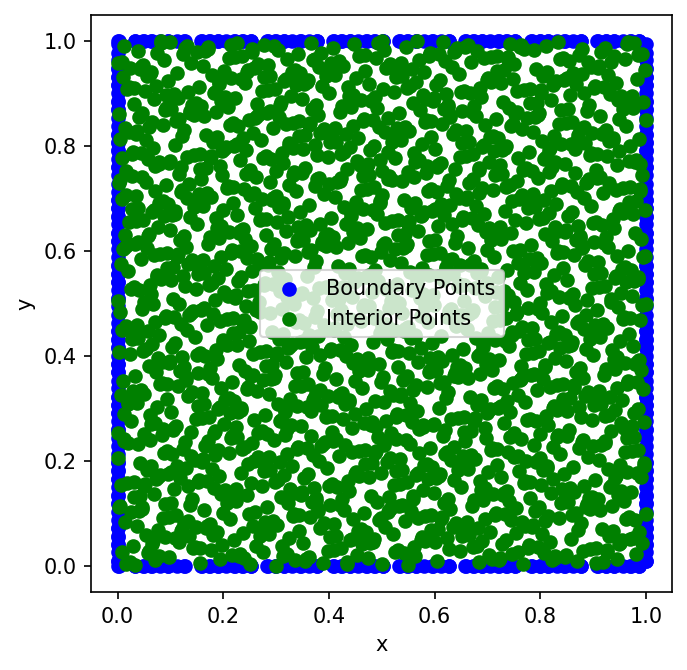

In [65]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_initial_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 2].detach().numpy(), c='blue', label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 2].detach().numpy(), c='green', label="Interior Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#plt.show()

print(input_tb_[0:n_tb, :])
print(output_tb_[0:n_tb, :])
print(input_tb_[n_tb:, :])
print(output_tb_[n_tb:, :])